<a href="https://colab.research.google.com/github/tushant-akar/CS367-Artifical-Intelligence-Lab/blob/main/Traveling_Salesman_Problem_using_Hopfield_Network_(Lab_6_Problem_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
import seaborn as sns

In [76]:
class HopfieldTSP:
    def __init__(self, n_cities: int, temperature: float = 0.01, learning_rate: float = 0.01):
        self.n_cities = n_cities
        self.n_neurons = n_cities * n_cities
        self.temperature = temperature
        self.learning_rate = learning_rate
        self.params = self._calculate_parameters()
        self.cities = np.random.rand(n_cities, 2)
        self.weights = np.zeros((self.n_neurons, self.n_neurons))
        self.bias = np.zeros(self.n_neurons)
        self.energy_history = []
        self._initialize_network()

    def _calculate_parameters(self) -> dict:
        return {
            'A': 500.0 + (self.n_cities * 12),
            'B': 500.0 + (self.n_cities * 20),
            'C': 200.0 + (self.n_cities * 8),
            'D': 500.0 + (self.n_cities * 30),
            'E': 100.0 + (self.n_cities * 3),
        }

    def _calculate_distances(self) -> np.ndarray:
        diff = self.cities[:, np.newaxis] - self.cities
        return np.sqrt(np.sum(diff**2, axis=2))

    def _initialize_network(self) -> None:
        distances = self._calculate_distances()
        A, B, C, D, E = self.params.values()

        for x in range(self.n_cities):
            for i in range(self.n_cities):
                for y in range(self.n_cities):
                    for j in range(self.n_cities):
                        idx1 = x * self.n_cities + i
                        idx2 = y * self.n_cities + j

                        weight = 0.0
                        if x == y and i != j:
                            weight -= A
                        if i == j and x != y:
                            weight -= A
                        if (x == (y + 1) % self.n_cities):
                            weight -= B * distances[i, j]
                        if x == y and i == j:
                            weight += C
                        if (x == (y + 1) % self.n_cities):
                            weight += D * np.exp(-distances[i, j] / E)

                        self.weights[idx1, idx2] = weight

        self.bias = C * np.ones(self.n_neurons)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
      x_scaled = x / self.temperature
      return np.where(
          x_scaled >= 0,
          1 / (1 + np.exp(-x_scaled)),
          np.exp(x_scaled) / (1 + np.exp(x_scaled))
      )

    def calculate_energy(self, state: np.ndarray) -> float:
        main_energy = -0.5 * np.dot(state, np.dot(self.weights, state)) - np.dot(self.bias, state)
        reshape_state = state.reshape(self.n_cities, self.n_cities)
        row_penalty = np.sum((np.sum(reshape_state, axis=0) - 1) ** 2)
        col_penalty = np.sum((np.sum(reshape_state, axis=1) - 1) ** 2)
        return main_energy + self.params['A'] * (row_penalty + col_penalty)

    def iterative_improvement(self, state: np.ndarray) -> np.ndarray:
        for _ in range(10):
            for i in range(self.n_neurons):
                input_sum = np.dot(self.weights[i], state) + self.bias[i]
                state[i] = self.sigmoid(input_sum) + np.random.normal(0, 0.01)
        return np.clip(state, 0, 1)

    def solve(self, max_iterations: int = 1000, convergence_threshold: float = 1e-6) -> Tuple[np.ndarray, List[float]]:
      state = np.random.uniform(0, 1, self.n_neurons)
      self.energy_history = []
      initial_temperature = self.temperature

      with tqdm(total=max_iterations, desc="Solving TSP") as pbar:
          for iteration in range(max_iterations):
              self.temperature = initial_temperature * (1 - iteration / max_iterations)
              old_energy = self.calculate_energy(state)

              input_sum = np.dot(self.weights, state) + self.bias
              state = self.sigmoid(input_sum)
              state = self.iterative_improvement(state)

              new_energy = self.calculate_energy(state)
              self.energy_history.append(new_energy)

              pbar.update(1)
              pbar.set_postfix({'Energy': f'{new_energy:.2f}'})

              if np.abs(new_energy - old_energy) < convergence_threshold:
                  pbar.close()
                  print(f"Converged after {iteration + 1} iterations.")
                  break

      final_state = (state > 0.5).astype(int)
      return final_state.reshape(self.n_cities, self.n_cities), self.energy_history


    def visualize_solution(self, solution: np.ndarray) -> None:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        route = np.where(solution == 1)[1]
        plt.scatter(self.cities[:, 0], self.cities[:, 1], c='red', s=100, label='Cities')
        for i in range(len(route)):
            start, end = self.cities[route[i]], self.cities[route[(i + 1) % len(route)]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      head_width=0.03, head_length=0.05, fc='blue', ec='blue', alpha=0.6)
        plt.title('TSP Route')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.energy_history)
        plt.title('Energy Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('Energy')

        plt.tight_layout()
        plt.show()

Solving TSP:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-76-58ca8d34d73f>:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x_scaled)),
<ipython-input-76-58ca8d34d73f>:59: RuntimeWarning: overflow encountered in exp
  np.exp(x_scaled) / (1 + np.exp(x_scaled))
<ipython-input-76-58ca8d34d73f>:59: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(x_scaled) / (1 + np.exp(x_scaled))
Solving TSP:   0%|          | 1/1000 [00:00<00:33, 29.48it/s, Energy=2488.06]<ipython-input-76-58ca8d34d73f>:59: RuntimeWarning: invalid value encountered in divide
  np.exp(x_scaled) / (1 + np.exp(x_scaled))
Solving TSP: 100%|██████████| 1000/1000 [00:40<00:00, 24.59it/s, Energy=-6478.84]


Total distance: 4.30
Final energy: -6478.84


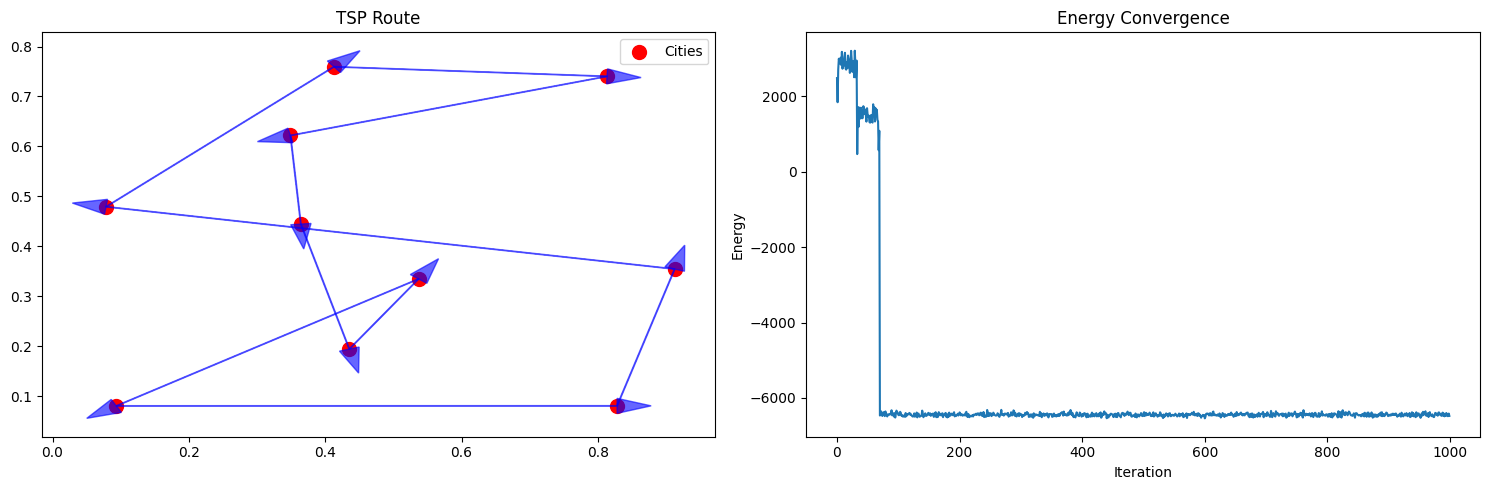

In [77]:
def main():
    n_cities = 10
    tsp = HopfieldTSP(n_cities)

    solution, energy_history = tsp.solve()

    total_distance = 0
    route = np.where(solution == 1)[1]
    for i in range(len(route)):
        start, end = tsp.cities[route[i]], tsp.cities[route[(i + 1) % len(route)]]
        total_distance += np.sqrt(np.sum((start - end) ** 2))

    print(f"Total distance: {total_distance:.2f}")
    print(f"Final energy: {energy_history[-1]:.2f}")

    tsp.visualize_solution(solution)


if __name__ == "__main__":
    main()